In [23]:
import database_utility
import baseball_models
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

Load in our database helper in case we need to pull data

In [ ]:
sqlite_file = 'baseball_data.sqlite'
dh = database_utility.DatabaseHelper(sqlite_file, 'baseball_key_joiner.csv')
#This will give a ValueError when using pd.read_json if the path doesn't exist
filepath = r'C:\Users\Chris\Google Drive\Programming\Baseball\Web Scraping\bbref_scraper\bbref_scraper\bbref.jl'

<h3> Batting DF Feature Importance </h3>

Run this cell if we need to create features because the CSV isn't there

In [ ]:
%%time
batting_df = dh.calc_batting_fd_score(start_date = '2018-01-01', end_date = '2018-12-31')
results = fe.offset_avgs(df=batting_df, ytd=True, moving=True, verbose=True)
feature_df_b = results[0]
feature_df_b['fd_score'] = results[1]

Otherwise, load in the data from a CSV and perform some basic cleaning

In [11]:
#feature_df_b.to_csv('CSV/batting_df_2018_avg_features.csv', index=False, header=True)
feature_df_b = pd.read_csv('CSV/batting_df_2018_avg_features.csv')

#need to sort by date for training model
#feature_df_b = pd.merge(feature_df_b, batting_df[['game_id', 'game_date']], on='game_id')
feature_df_b.sort_values('game_date', inplace=True)
#make sure we drop any validation data
feature_df_b = feature_df_b[feature_df_b['game_date'] < '2018-08-01']
feature_df_b.drop('game_date', inplace=True, axis=1)

I take the top 10 most correlated features with the target and plot them as a heatmap.  None of these features are highly correlated with the target at all.  This is interesting, but makes sense - the FD_Score for batting is composed of 8 different attributes, so one individual feature being highly correlated is less likely. 

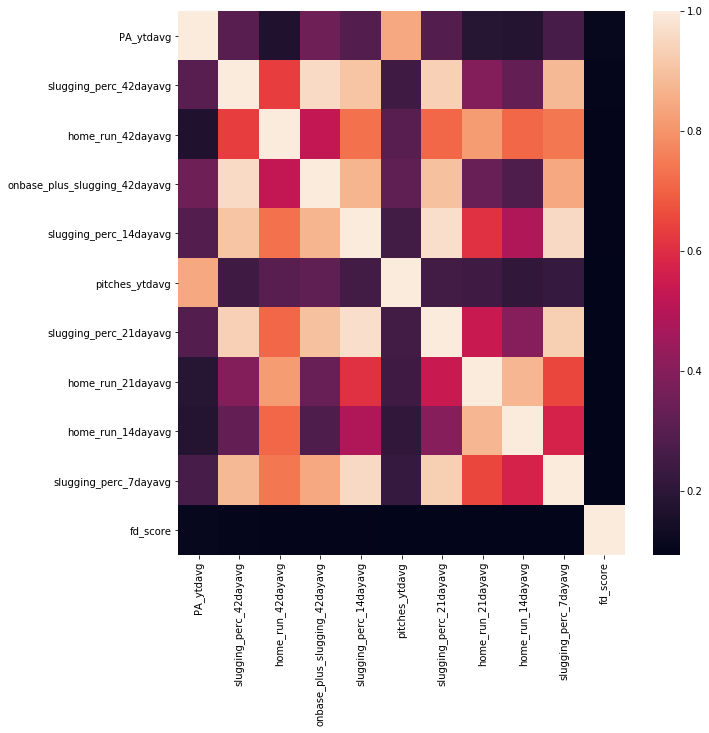

In [94]:
corr_df_b = feature_df_b.drop(['fd_score', 'game_id'], axis=1).apply(lambda x: x.corr(feature_df_b['fd_score']))
corr_df_b = corr_df_b.sort_values(ascending=False).iloc[0:10]

cols = list(corr_df_b.index.values)
cols.append('fd_score')

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(feature_df_b[cols].corr(), xticklabels=cols, yticklabels=cols)

My next step is to look at feature importance via XGBoost and SHAP values and also evaluate model performance

In [44]:
import xgboost
import baseball_models
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

cv = CrossValidator()
X, y, tscv = cv.train_test_split(feature_df_b.drop('fd_score', axis=1), feature_df_b['fd_score'], num_splits=100)

xgbreg = xgboost.XGBRegressor(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

Cross Validate uses sklearns TimeSeriesSplit to perform walk-forward cross validation for the number of splits indicated in the train_test_split function above.  I run this because I am curious if YTD features 'get better' as the year goes on.  I would expect to see the test MAE improve over the course of the year (as iterations increase)

In [ ]:
cv.cross_validate(X, y, tscv, xgbreg)

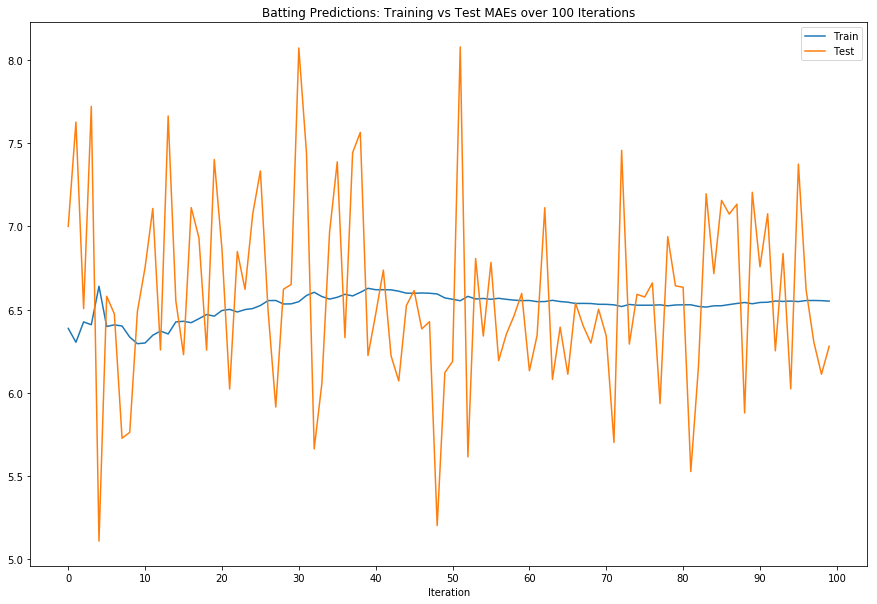

In [75]:
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(y=cv.train_maes, x=np.arange(0, len(cv.train_maes)))
ax = sns.lineplot(y=cv.test_maes, x=np.arange(0, len(cv.train_maes)), ax=ax, legend='brief')
ax.set_xticks(ticks=np.arange(0,len(cv.test_maes)+1, 10))
ax.set_xlabel(xlabel="Iteration")
ax.set_title("Batting Predictions: Training vs Test MAEs over 100 Iterations")
ax.legend(labels=['Train','Test'])
plt.show()

It looks like there is a slight trend - let's validate that the variance in the test MAE gets less as we get farther through the year.

In [101]:
print("STDev for the first 50 iterations is: {:.2f} ".format(np.std(cv.test_maes[0:50])))
print("STDev for the last 50 iterations is: {:.2f}".format(np.std(cv.test_maes[51:100])))

STDev for the first 50 iterations is: 0.63 
STDev for the last 50 iterations is: 0.50


Next, I want to identify which features are actually contributing to the model's predictions using SHAP values

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83

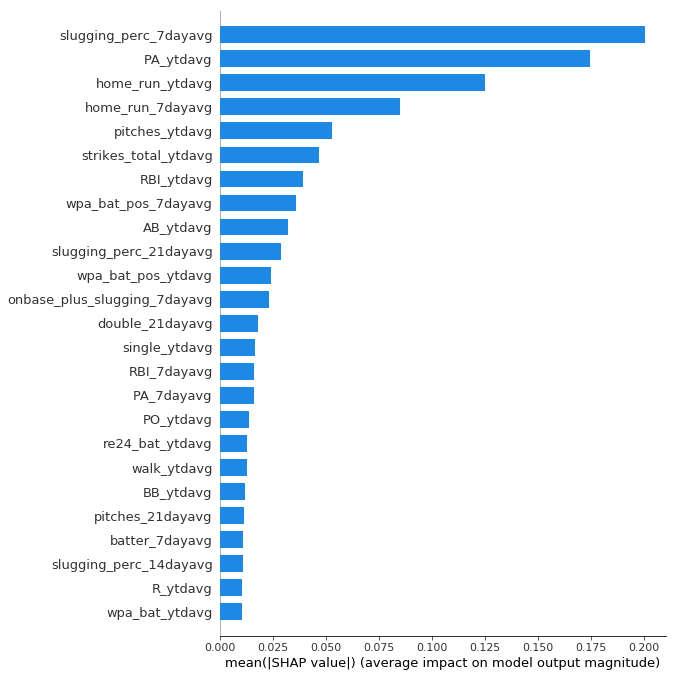

In [105]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(cv.model)
shap_values = explainer.shap_values(cv.X_train)
shap.summary_plot(shap_values, list(cv.X_train.columns.values), plot_type="bar", max_display=25)

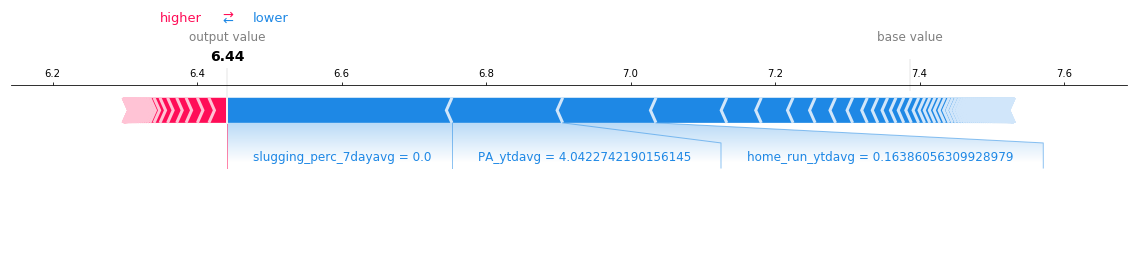

In [135]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], cv.X_train.iloc[0,:], matplotlib=True)

Finally, we can validate this by looking at some reg plots - we should see linear trends in these top features that didn't necessarily show up in the correlation matrix above. 

In [72]:
#take the top 10 in SHAP values
top_shap_b = feature_df_b[['slugging_perc_7dayavg', 'home_run_ytdavg', 'PA_ytdavg', 'home_run_7dayavg', 'pitches_ytdavg', 'slugging_perc_21dayavg', 'AB_ytdavg', 'strikes_total_ytdavg', 're24_bat_14dayavg', 'RBI_ytdavg', 'fd_score']]

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


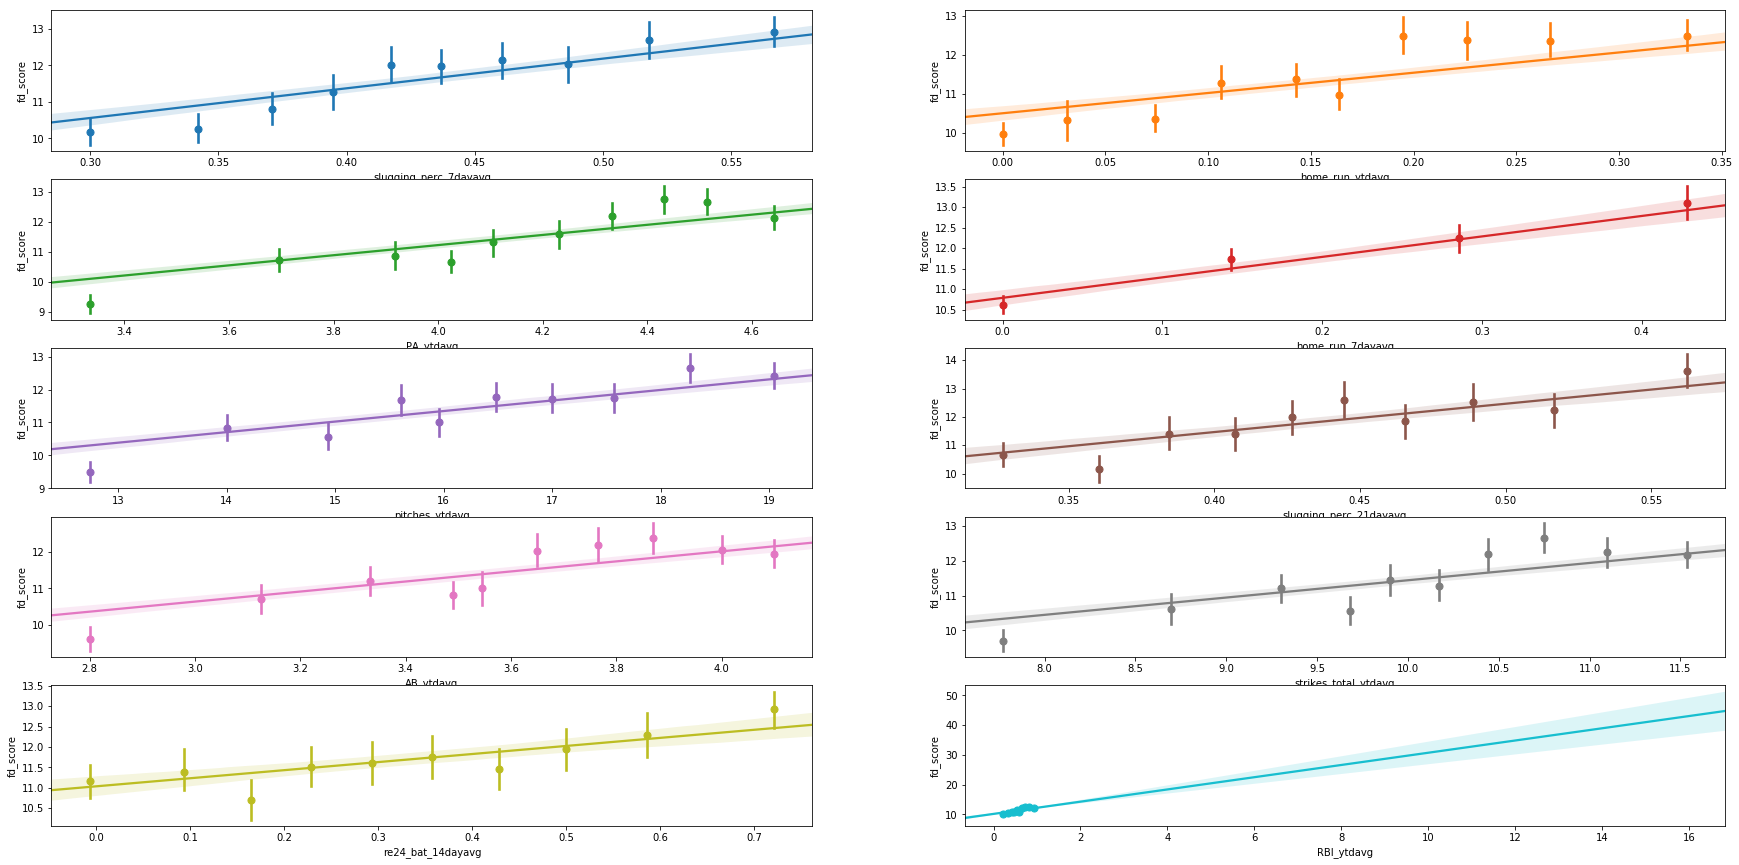

In [90]:
fig, ax = plt.subplots(5,2, figsize = (30,15), sharex=False)

axes = ax.ravel()

for i, col in enumerate(top_shap_b.columns):
    if i < len(axes):
        ax = sns.regplot(x=top_shap_b[col], y=top_shap_b['fd_score'], ax=axes[i], x_bins=10)
        ax.set(xlabel=col)